In [ ]:
!pip install rdkit
!pip install pandas
import pandas as pd
import math
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize import rdMolStandardize
import matplotlib.pyplot as plt

In [ ]:
# The relevant columns of the whole dataset containing 49077 entries is loaded and converted to a Pandas DataFrame:

df = pd.read_csv('CHEMBL387_IC50.csv', sep=';', usecols =['Molecule ChEMBL ID', 'Smiles','Assay Description','Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'AlogP', 'Molecular Weight'])

In [ ]:
# Display for each column how many entries have no value ('NaN'):
df.isnull().sum()

Molecule ChEMBL ID       0
Molecular Weight         1
AlogP                 1501
Smiles                 102
Standard Type            0
Standard Relation     1508
Standard Value        1507
Standard Units        1430
Assay Description        0
dtype: int64

In [ ]:
# Drop all rows in which NaN values are present:
# (Note: This may drop more IC50 values than necessary if only ChEMBL ID, Assay Description, AlogP or Molecular Weight have an entry as 'NaN'.)
# 2990 entries are dropped. After this, the dataset has a size of 46087 entries.

df.dropna(inplace=True)

In [ ]:
# Drop all rows which have units other than nM and ug.mL-1:
# 28 entries are dropped. After this, the dataset has a size of 46059 entries.

df.drop(df[(df['Standard Units'] != 'nM') & (df['Standard Units'] !='ug.mL-1')].index, inplace = True)

In [ ]:
# Function to convert a value in 'ug.mL-1' into a value in 'nM':

def converter(value, MW):
  return value*1000000/MW

# Function to return 'True' if 'substring' is within 'string':

def assay_type(substring, string):
    if f"{substring}" in string:
        return True
    return False

# Function to convert IC50 values into pIC50 values:

def nM_to_plog (ic50):
  ic50 = ic50 / (10**9)
  ic50 = (-1)*math.log10(ic50)
  return ic50

# Function to standardize SMILES:

def standardise_smiles(smiles):
    return rdMolStandardize.StandardizeSmiles(smiles)

In [ ]:
# Drop all rows which contain molecules whith more than one fragment. This are largely salts (such as hydrochloride salt of an amine):
# 1983 entries are dropped. After this, the dataset has a size of 44076 entries.

# A function that returns True if a SMILES contains one fragment and False otherwise
def smiles_contains_one_fragment(smiles):
    """Check if the given SMILES string represents a molecule with exactly one fragment.

    Args:
      smiles (str): SMILES representation of the molecule.

    Returns:
      bool: True if the molecule has exactly one fragment, False otherwise.
    """
    # Convert the SMILES string to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    # Use GetMolFrags to find the disconnected fragments in the molecule
    fragments = rdmolops.GetMolFrags(mol)

    # Check if the number of fragments is 1
    return len(fragments) == 1

# Create a mask that is True if the SMILES contains one fragment
mask = df['Smiles'].apply(smiles_contains_one_fragment)

# Select rows that contain only one fragment
df = df[mask]



In [ ]:
# Remove all rows which have charged molecules. Since fragmented molecules have already been removed (so all salts with both ion and counterion), this concerns only molecules without counterions.
# I checked separately: The dataset does not contain any molecules featuring metal atoms.
# 36 entries are dropped. After this, the dataset has a size of 44040 entries.

# Add a column containing Mol objects to the DataFrame
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Smiles', molCol='mol')

# Create a mask that is True if molecules are uncharged
mask = df['mol'].apply(rdmolops.GetFormalCharge) == 0

# Select rows that contain uncharged molecules
df = df[mask]

# This part would be used to remove rows containing metal atoms. However, no entries are removed for this dataset.
# A function that returns whether the molecule contains no metal
def no_metal(mol):
    # Define the SMARTS pattern for metals
    metal_smarts = "[!#1;!B;!C;!O;!N;!S;!P;!F;!Cl;!Br;!I;!c;!o;!n;!s;!p]"

    metal_query = Chem.MolFromSmarts(metal_smarts)

    # Return True if no metal is found, False otherwise
    return not mol.HasSubstructMatch(metal_query)

# Create a mask that is True if the molecule does not contain a metal
mask = df['mol'].apply(no_metal)

# Select rows where no metal is present
df = df[mask]

# Remove column with mol objects again, because it is no needed for the machine learning part.
df = df[['Molecule ChEMBL ID','Smiles','Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'AlogP','Molecular Weight','Assay Description']]

In [ ]:
# Standardize smiles:

df['Smiles'] = df['Smiles'].apply(standardise_smiles)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[16:58:01] Initializing MetalDisconnector
[16:58:01] Running MetalDisconnector
[16:58:01] Initializing Normalizer
[16:58:01] Running Normalizer
[16:58:01] Initializing MetalDisconnector
[16:58:01] Running MetalDisconnector
[16:58:01] Initializing Normalizer
[16:58:01] Running Normalizer
[16:58:01] Initializing MetalDisconnector
[16:58:01] Running MetalDisconnector
[16:58:01] Initializing Normalizer
[16:58:01] Running Normalizer
[16:58:01] Initializing MetalDisconnector
[16:58:01] Running MetalDisconnector
[16:58:01] Initializing Normalizer
[16:58:01] Running Normalizer
[16:58:01] Initializing MetalDisconnector
[16:58:01] Running MetalDisconnector
[16:58:01] Initializing Normalizer
[16:58:01] Running Normalizer
[16:58:01] Initializing MetalDisconnector
[16:58:01] Running MetalDisconnector
[16:58:01] Initializing Normalizer
[16:58:01] Running Normalizer
[16:58:01] Initializing MetalDisconnector
[16:58:01] Running MetalDis

In [ ]:
# If in column 'Standard Units' there is an entry not equal to 'nM', then within the same row, the entry in column 'Standard Value' (IC50)
# is converted to 'nM'.
# The previous IC50 values are overwritten by the resulting list with adapted units.
# So this function is used to convert all values with unit 'ug.mL-1' into values with unit 'nM'.

df['Standard Value'] = [converter(float(x),float(y)) if z != 'nM' else x for x,y,z in zip(df['Standard Value'], df['Molecular Weight'], df['Standard Units'])]

In [ ]:
# Remove all rows that have ranged indicated for the IC50 value ('>','<'):
# 9627 entries are dropped. After this, the dataset has a size of 34413 entries.

df.drop(df[df["Standard Relation"] != "'='"].index, inplace=True)

In [ ]:
# Remove all rows which are duplicates of other rows based on standardized Smiles:
# 4363 entries are dropped. After this, the dataset has a size of 30050 entries.

df.drop_duplicates(inplace=True, subset=['Smiles'])

In [ ]:
# Remove all rows which contain values equal or smaller 0. The pIC50 would not be defined for these values (and they don't make sense!)
# 2 entries are dropped. After this, the dataset has a size of 30048 entries. This is the final dataset size.

df.drop(df[df['Standard Value'] <= 0].index, inplace=True)

In [ ]:
# Create new column 'pIC50' from IC50 values in nM:

df['pIC50'] = df['Standard Value'].apply(nM_to_plog)

In [ ]:
# Save Pandas DataFrame to csv file:

df.to_csv('allassays_nodupl_nofrag_.csv')

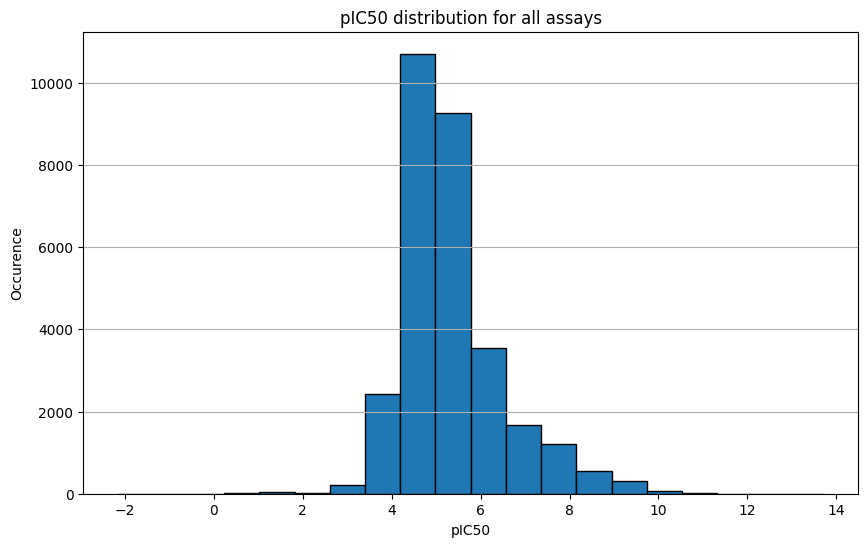

In [ ]:
# Plot histogram for distribution of pIC50 values:

plt.figure(figsize=(10, 6))
plt.hist(df['pIC50'], bins=20, edgecolor='black')
plt.title('pIC50 distribution for all assays')
plt.xlabel('pIC50')
plt.ylabel('Occurence')
plt.grid(axis='y')
plt.show()

This code can be used if you want to reduce the dataset to subsets such as only MTT assay and within that assay only to incubation times of 48 h or 72 h (most frequent incubation times).

In [ ]:
# Filter dataframe by applying a boolean mask: Only rows containing the string 'MTT' in column 'Assay Decription' are being kept:

mask_MTT = df.apply(lambda x: assay_type('MTT', x['Assay Description']), axis = 1)
df_MTT = df[mask_MTT]

In [ ]:
# Filter dataframe by applying a boolean mask: Only rows containing the string '48'/'72' in column 'Assay Decription' are being kept:

mask_48 = df.apply(lambda x: assay_type('48', x['Assay Description']), axis = 1)
df_48 = df_MTT[mask_48]

mask_72 = df.apply(lambda x: assay_type('72', x['Assay Description']), axis = 1)
df_72 = df_MTT[mask_72]

<ipython-input-80-334bdc4582eb>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_48 = df_MTT[mask_48]
<ipython-input-80-334bdc4582eb>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_72 = df_MTT[mask_72]
